Created by: Srikar Madarapu

## Model Training for Semantic Image Search
#### The training process leverages the CLIP (Contrastive Language-Image Pretraining) model for generating embeddings that capture semantic relationships between images and text

### Libraries: 
- **json**: A built-in Python library to parse, manipulate, and serialize JSON data (JavaScript Object Notation), which is commonly used for data exchange.

- **numpy**: A powerful library for numerical computations in Python, providing support for arrays, matrices, and a collection of mathematical functions.

- **random**: A built-in library for generating random numbers and selections, useful for creating random data or sampling.

- **datetime**: A Python library for working with dates and times, allowing operations like time formatting and date calculations.

- **PIL (Pillow)**: An image-processing library that extends Python's image capabilities with support for opening, manipulating, and saving many image file formats.
- **matplotlib.pyplot**: A plotting library in Python used for creating static, interactive, and animated visualizations such as graphs and charts.

- **torch (PyTorch)**: An open-source deep learning library focused on flexibility and GPU-accelerated computation. It's widely used for building and training neural networks.

  - **torch.nn**: A module within PyTorch for constructing neural network layers and models.
  - **torch.nn.functional**: Provides functions for neural network operations, like activation functions and loss calculations, often used in model layers.
  - **torch.utils.data**: Includes tools like `DataLoader` and `Dataset` to handle data loading and preprocessing in model training.
  - **torch.amp**: Offers utilities like `autocast` and `GradScaler` for automatic mixed precision, optimizing model training performance by using both float16 and float32 data types.

- **transformers**: A library by Hugging Face providing pre-trained models and tokenizers for NLP (Natural Language Processing) tasks, including BERT, GPT, and more.

- **prefetch_generator**: Provides `BackgroundGenerator`, which prefetches data in the background to improve data loading performance during model training.

- **torchvision**: A PyTorch library specialized in computer vision, offering datasets, pre-trained models, and transforms for image processing.

- **albumentations**: A fast and flexible image augmentation library for computer vision, with a rich set of transformations to improve model robustness.

  - **albumentations.pytorch**: An extension to convert Albumentations output into PyTorch tensors, making it easier to use with PyTorch models.

In [ ]:
!pip install numpy torch torchvision transformers prefetch_generator pillow albumentations


In [1]:
# Standard libraries
import json
import numpy as np
import random
from datetime import datetime
from PIL import Image
import matplotlib.pyplot as plt

# PyTorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.amp import autocast, GradScaler

# Third-party libraries
from transformers import AutoTokenizer
from prefetch_generator import BackgroundGenerator
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

/home/smadarapu/.local/lib/python3.8/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


### Model Design and Implementation: Include annotated code blocks with detailed explanations, along with test cases for key methods.



1. **Activation Function**: QuickGELU
2. **Transformer Block**: ResidualAttentionBlock
    - **d_model**: Dimensionality of the model embeddings.
    - **n_head**: Number of attention heads.
    - **attn**: Multi-head attention mechanism.
    - **ln_1, ln_2**: Layer normalization layers, applied before attention and MLP blocks.
    - **mlp**: Two-layer MLP with a QuickGELU activation in between.
    - **In forward**: a residual connection is added around the multi-head attention and MLP.

In [2]:
class QuickGELU(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(1.702 * x)

class ResidualAttentionBlock(nn.Module):
    def __init__(self, d_model: int, n_head: int):
        super().__init__()
        self.attn = nn.MultiheadAttention(d_model, n_head)
        self.ln_1 = nn.LayerNorm(d_model)
        self.mlp = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            QuickGELU(),
            nn.Linear(d_model * 4, d_model)
        )
        self.ln_2 = nn.LayerNorm(d_model)

    def forward(self, x: torch.Tensor, attn_mask: torch.Tensor = None):
        x = x + self.attn(self.ln_1(x), self.ln_1(x), self.ln_1(x), 
                         need_weights=False, attn_mask=attn_mask)[0]
        x = x + self.mlp(self.ln_2(x))
        return x

In [3]:
# Test ResidualAttentionBlock
d_model = 64
n_head = 4
x = torch.randn(10, 32, d_model)  # (sequence length, batch size, d_model)
block = ResidualAttentionBlock(d_model, n_head)
output = block(x)
print(f"ResidualAttentionBlock output shape: {output.shape}")
# Expected output: torch.Size([10, 32, 64])


ResidualAttentionBlock output shape: torch.Size([10, 32, 64])


3. **Vision Transformer**: VisionTransformer
    - input_resolution and patch_size define the number and size of patches.
    - conv1 extracts patches from the image.
    - class_embedding serves as a [CLS] token.
    - positional_embedding provides spatial information to each patch.
    - transformer applies multiple ResidualAttentionBlock layers.
    - The model outputs the representation of the [CLS] token.

In [4]:
class VisionTransformer(nn.Module):
    def __init__(self, input_resolution: int = 224, patch_size: int = 32,
                 width: int = 512, layers: int = 12, heads: int = 8):
        super().__init__()
        self.input_resolution = input_resolution
        self.conv1 = nn.Conv2d(3, width, kernel_size=patch_size, stride=patch_size, bias=False)
        
        scale = width ** -0.5
        self.class_embedding = nn.Parameter(scale * torch.randn(width))
        self.positional_embedding = nn.Parameter(scale * torch.randn((input_resolution // patch_size) ** 2 + 1, width))
        self.ln_pre = nn.LayerNorm(width)
        
        self.transformer = nn.Sequential(*[
            ResidualAttentionBlock(width, heads) for _ in range(layers)
        ])
        
        self.ln_post = nn.LayerNorm(width)

    def forward(self, x: torch.Tensor):
        # Shape: [batch_size, 3, resolution, resolution]
        x = self.conv1(x)  # Shape: [batch_size, width, grid, grid]
        
        # Reshape and permute
        x = x.reshape(x.shape[0], x.shape[1], -1)  # Shape: [batch_size, width, grid ** 2]
        x = x.permute(0, 2, 1)  # Shape: [batch_size, grid ** 2, width]
        
        # Prepend class token
        x = torch.cat([
            self.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device),
            x
        ], dim=1)  # Shape: [batch_size, grid ** 2 + 1, width]
        
        # positional embeddings
        x = x + self.positional_embedding.to(x.dtype)
        x = self.ln_pre(x)
        
        # Transformer blocks
        x = x.permute(1, 0, 2)  # Shape: [grid ** 2 + 1, batch_size, width]
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # Shape: [batch_size, grid ** 2 + 1, width]
        
        # Return the transformed CLS token
        x = self.ln_post(x[:, 0, :])
        
        return x

In [5]:
# Test VisionTransformer
vision_model = VisionTransformer()
image = torch.randn(2, 3, 224, 224)  # (batch size, channels, height, width)
image_features = vision_model(image)
print(f"VisionTransformer output shape: {image_features.shape}")
# Expected output: torch.Size([2, 512])


VisionTransformer output shape: torch.Size([2, 512])


4. **Text Transformer**: TextTransformer
    - token_embedding embeds text tokens.
    - positional_embedding provides information about token positions.
    - transformer applies multiple ResidualAttentionBlock layers.
    - Outputs [CLS] token after layer normalization.

In [7]:
class TextTransformer(nn.Module):
    def __init__(self, context_length: int = 77, vocab_size: int = 49408,
                 width: int = 512, layers: int = 12, heads: int = 8):
        super().__init__()
        self.context_length = context_length
        self.vocab_size = vocab_size
        
        self.token_embedding = nn.Embedding(vocab_size, width)
        self.positional_embedding = nn.Parameter(torch.empty(context_length, width))
        
        self.transformer = nn.Sequential(*[
            ResidualAttentionBlock(width, heads) for _ in range(layers)
        ])
        
        self.ln_final = nn.LayerNorm(width)
        
        # Initialize the positional embeddings
        self.initialize_parameters()

    def initialize_parameters(self):
        nn.init.normal_(self.positional_embedding, std=0.01)

    def forward(self, text: torch.Tensor):
        # Shape: [batch_size, context_length]
        x = self.token_embedding(text)  # Shape: [batch_size, context_length, width]
        
        # positional embeddings
        x = x + self.positional_embedding
        
        # Transformer blocks
        x = x.permute(1, 0, 2)  # Shape: [context_length, batch_size, width]
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # Shape: [batch_size, context_length, width]
        
        # Layer norm and mean pooling
        x = self.ln_final(x)
        x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)]
        
        return x

In [8]:
# Test TextTransformer
text_model = TextTransformer()
text = torch.randint(0, 49408, (2, 77))  # (batch size, context length)
text_features = text_model(text)
print(f"TextTransformer output shape: {text_features.shape}")
# Expected output: torch.Size([2, 512])


TextTransformer output shape: torch.Size([2, 512])


5. **CLIP Model**: CLIP
    - forward method processes both image and text inputs.
    - encode_image and encode_text methods use the vision and text transformers to return respective embeddings.

In [9]:
class CLIP(nn.Module):
    def __init__(self):
        super(CLIP, self).__init__()
        self.vision_model = VisionTransformer()
        self.text_model = TextTransformer()

    def forward(self, image, text):
        # Process the image through the vision model
        image_features = self.encode_image(image)
        
        # Process the text through the text model
        text_features = self.encode_text(text)
        
        return image_features, text_features

    def encode_image(self, image):
        """
        Encodes an image using the VisionTransformer.
        
        Args:
            image: Tensor of shape (B, 3, H, W) representing the batch of images.
        
        Returns:
            A tensor of shape (B, N, embed_dim) representing the image embeddings.
        """
        image_features = self.vision_model(image)
        # Typically, we take the representation of the [CLS] token (first token) after passing through the transformer
        # But here we return the full sequence, which can also be processed later for image-text matching
        return image_features  # Return the [CLS] token or representation for image

    def encode_text(self, text):
        """
        Encodes text using the TextTransformer.
        
        Args:
            text: Tensor of shape (B, L) representing the tokenized input text.
        
        Returns:
            A tensor of shape (B, L, embed_dim) representing the text embeddings.
        """
        text_features = self.text_model(text)
        # Similar to images, we often take the representation of the [CLS] token
        return text_features  # Return the [CLS] token or representation for text

In [10]:
# Test CLIP model
clip_model = CLIP()
image = torch.randn(2, 3, 224, 224)  # (batch size, channels, height, width)
text = torch.randint(0, 49408, (2, 77))  # (batch size, context length)
image_features, text_features = clip_model(image, text)
print(f"CLIP Image features shape: {image_features.shape}")
print(f"CLIP Text features shape: {text_features.shape}")
# Expected output: torch.Size([2, 512]), torch.Size([2, 512])


CLIP Image features shape: torch.Size([2, 512])
CLIP Text features shape: torch.Size([2, 512])


5. **`contrastive_loss` Function**

This function implements a **contrastive loss** that encourages image and text embeddings to align when they are from the same pair and be dissimilar when they are not. Below is an annotated breakdown of how it works, as well as a simple test case to verify functionality.

1. **Normalization**:  
   - `F.normalize(image_embeddings, dim=-1)` and `F.normalize(text_embeddings, dim=-1)` convert each embedding to a unit vector. This step is crucial to calculate cosine ground_clip_ground_clip_similarity effectively, as it ensures embeddings lie on a hypersphere.
   
2. **Cosine Similarity Matrix**:
   - `logits_per_image = torch.matmul(image_embeddings, text_embeddings.T) / temperature` computes the pairwise cosine similarity between each image and text embedding, scaled by a `temperature` parameter. Lowering `temperature` sharpens the similarities, which can improve contrastive learning performance.
   - `logits_per_text = logits_per_image.T` stores the transposed similarity matrix for text-to-image matching.

3. **Ground-Truth Labels**:
   - `labels = torch.arange(batch_size, device=image_embeddings.device)` creates a set of labels (0, 1, ..., `batch_size - 1`) where each label corresponds to a specific pair. This is used as the target when computing cross-entropy, so the model learns that each image embedding should match its paired text embedding.

4. **Cross-Entropy Loss**:
   - `loss_i2t` and `loss_t2i` compute the cross-entropy losses for the image-to-text and text-to-image directions, respectively, using `logits_per_image` and `logits_per_text`. This encourages image embeddings to align with the correct text embeddings and vice versa.

5. **Averaging**:
   - The final loss is the average of `loss_i2t` and `loss_t2i`, which balances the objective between image-to-text and text-to-image matching.

- **Output**: The test will output a single scalar representing the contrastive loss. Given random embeddings, the loss will be relatively high, as they are not aligned.
- **Interpretation**: After training, we expect this loss value to decrease as paired image and text embeddings become closer in the embedding space.

In [11]:
def contrastive_loss(image_embeddings, text_embeddings, temperature=0.07):
    # Normalize embeddings to unit vectors
    image_embeddings = F.normalize(image_embeddings, dim=-1)
    text_embeddings = F.normalize(text_embeddings, dim=-1)

    # Compute cosine similarity matrix
    logits_per_image = torch.matmul(image_embeddings, text_embeddings.T) / temperature
    logits_per_text = logits_per_image.T

    # Create ground-truth labels (0, 1, ..., batch_size - 1) for matching pairs
    batch_size = image_embeddings.size(0)
    labels = torch.arange(batch_size, device=image_embeddings.device)

    # Compute cross-entropy loss for both image-to-text and text-to-image directions
    loss_i2t = F.cross_entropy(logits_per_image, labels)
    loss_t2i = F.cross_entropy(logits_per_text, labels)
    
    # Average the two losses
    loss = (loss_i2t + loss_t2i) / 2
    return loss


In [17]:
# Test case for contrastive_loss
batch_size = 4
embed_dim = 512

# Generate random image and text embeddings for testing
image_embeddings = torch.randn(batch_size, embed_dim)
text_embeddings = torch.randn(batch_size, embed_dim)

# Compute contrastive loss
loss = contrastive_loss(image_embeddings, text_embeddings)
print(f"Contrastive Loss: {loss.item()}")


Contrastive Loss: 1.6688052415847778


### Training Process: Detail the training setup, data preparation, and hyperparameters. Show sample logs or outputs.


1. **`DataLoaderX` Class**:
   - Extends `DataLoader` to use `BackgroundGenerator` for faster data loading by prefetching data in the background.

2. **`LimitedCOCODataset` Class**:
   - Inherits from `torch.utils.data.Dataset` to define a custom dataset.
   - Initializes with the path to images (`image_dir`), an annotation file (`annotation_file`), and several configuration options:
     - `num_images`: Limits the number of images used.
     - `transform`: Defines transformations for the images.
     - `tokenizer`: Tokenizes captions if provided, which is helpful for contrastive learning tasks like CLIP.
     - `max_length`: Maximum token length for captions.
     - `unique_images`: Controls whether to sample unique images only.

3. **Image Transformation with `Albumentations`**:
   - *transform* resizes images to a specified shape and normalizes pixel values, improving consistency for models like CLIP.

- **Image batch shape**: (4, 3, 224, 224), indicating a batch of 4 images, each with 3 channels and 224x224 pixels.
- **Caption batch shape**: (4, 77), representing a batch of 4 tokenized captions, each padded or truncated to 77 tokens.


In [18]:

class DataLoaderX(DataLoader):
    def __iter__(self):
        return BackgroundGenerator(super().__iter__())

class LimitedCOCODataset(Dataset):
    def __init__(self, image_dir, annotation_file, num_images=10000, transform=None, seed=42, tokenizer=None, max_length=77,unique_images=1):
        with open(annotation_file, 'r') as f:
            self.annotations = json.load(f)
        self.image_dir = image_dir
        self.transform = transform
        self.tokenizer = tokenizer  
        self.max_length = max_length  
        
        # Pre-process annotations and limit the dataset size
        all_image_captions = []
        if unique_images==1:
            image_ids = set()
        
        # Collect all unique image IDs with their captions
        for ann in self.annotations['annotations']:
            image_id = ann['image_id']
            if unique_images==1:
                if image_id not in image_ids:
                    image_ids.add(image_id)
                    all_image_captions.append({
                        'image_id': image_id,
                        'caption': ann['caption']
                        })
            else:
                all_image_captions.append({
                        'image_id': image_id,
                        'caption': ann['caption']
                        })

        
        #print(len(self.annotations['annotations']))
        # Randomly sample num_images from the dataset
        random.seed(seed)
        self.image_captions = random.sample(all_image_captions, min(num_images, len(all_image_captions)))
        print(f"Dataset initialized with {len(self.image_captions)} images")
        
    def __len__(self):
        return len(self.image_captions)
    
    def __getitem__(self, idx):
        ann = self.image_captions[idx]
        image_id = ann['image_id']
        caption = ann['caption']
        image_path = f"{self.image_dir}{image_id:012d}.jpg"
        
        # Load the image using numpy for faster processing
        image = np.array(Image.open(image_path).convert("RGB"))
        
        # Apply image transformation if provided
        if self.transform:
            transformed = self.transform(image=image)
            image = transformed['image']
        
        # Tokenize the caption if a tokenizer is provided
        if self.tokenizer:
            tokenized_caption = self.tokenizer(
                caption, 
                padding='max_length', 
                truncation=True, 
                max_length=self.max_length, 
                return_tensors="pt"
            )
            input_ids = tokenized_caption['input_ids'].squeeze()  # Remove batch dimension
        else:
            input_ids = caption  # Fallback if tokenizer is not provided
        
        return image, input_ids

# Faster image transforms using Albumentations
transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(
        mean=[0.48145466, 0.4578275, 0.40821073],
        std=[0.26862954, 0.26130258, 0.27577711]
    ),
    ToTensorV2()
])

In [19]:

# Test case for LimitedCOCODataset
image_dir = "coco/images/train2017/"  # Directory with COCO images
annotation_file = "coco/annotations/captions_train2017.json"  # COCO annotations file
num_images = 10  # Limit for testing

# Create dataset
dataset = LimitedCOCODataset(image_dir, annotation_file, num_images=num_images, transform=transform,
                             tokenizer=tokenizer, max_length=77, unique_images=1)

# Create DataLoader
dataloader = DataLoaderX(dataset, batch_size=4, shuffle=True)

# Iterate through a few batches
for images, captions in dataloader:
    print("Image batch shape:", images.shape)  # Should be [batch_size, 3, 224, 224]
    print("Caption batch shape:", captions.shape)  # Should be [batch_size, max_length]
    break  # Test one batch only

Dataset initialized with 10 images
Image batch shape: torch.Size([4, 3, 224, 224])
Caption batch shape: torch.Size([4, 77])


This code sets up a training function `train_model` to train a CLIP-like model on a custom dataset derived from the COCO captions dataset. Key parts of the function include the custom DataLoader with background loading, mixed-precision training with gradient scaling, and a learning rate scheduler. Below is an annotated breakdown, including modifications and additional details to ensure clarity.

### `train_model` Function

1. **DataLoader Setup**:
   - `DataLoaderX` provides background loading, leveraging the `pin_memory=True` option for efficiency.
   
2. **Mixed-Precision Training**:
   - Uses `GradScaler` and `autocast` to enable mixed-precision training, optimizing memory and speed.

3. **Optimizer and Scheduler**:
   - `AdamW` is used with weight decay, while `CosineAnnealingLR` gradually reduces the learning rate.
   
4. **Training Loop**:
   - In each epoch, images and captions are loaded onto the GPU.
   - Embeddings are generated using `model.encode_text()` and `model.encode_image()`.
   - Contrastive loss is calculated using `contrastive_loss`.
   - Scaler and optimizer handle backpropagation and parameter updates.

5. **Model Checkpointing**:
   - Saves the model’s current state every epoch, storing parameters and optimizer state.

### Loading the Dataset and Training the Model

Below is how you initialize `train_dataset` using `LimitedCOCODataset` and start training the model using `train_model`.


By following these steps, the CLIP model should be able to train effectively on the COCO dataset, creating image and text embeddings optimized for contrastive learning.

`Hyperparameters`:
 - trial - 6
 - num_images=120000
 - lr=1e-4
 - epochs = 50
 - unique_images=0
 - optim = adamw
 - scheduler = CosineAnnealingLR

In [ ]:


def train_model(model, train_dataset, num_epochs=2, batch_size=128, num_workers=4,lr=1e-4):
    
    # Use custom DataLoader with background loading
    train_dataloader = DataLoaderX(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )
    
    # Initialize gradient scaler for mixed precision training
    scaler = GradScaler('cuda')
    
    # Define optimizer with weight decay
    optimizer = torch.optim.AdamW(
        list(model.vision_model.parameters()) + list(model.text_model.parameters()),
        lr=lr,
        weight_decay=0.01
    )
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    # Move models to device and set to train mode
    #vision_model = vision_model.to(device)
    #text_model = text_model.to(device)
    #vision_model.train()
    #text_model.train()

    model = model.to(device)
    model.train()

    epoch_losses = []
    for epoch in range(num_epochs):
        total_loss = 0.0
        for images, captions in train_dataloader:
            images = images.to(device, non_blocking=True)
            captions = captions.to(device, non_blocking=True)
            # Mixed precision training
            with autocast('cuda'):
                text_embeddings = model.encode_text(captions)
                image_embeddings = model.encode_image(images)
                loss = contrastive_loss(image_embeddings, text_embeddings)
            
            # Gradient scaling
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_dataloader)
        epoch_losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")
        scheduler.step()

    current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
    savedmodelname = f'model_save/checkpoint_{current_time}.pth'
    torch.save({
        'epoch': epoch,  # Save the current epoch number
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': avg_loss,  # Save the losses (optional)
        }, savedmodelname)
    return model,savedmodelname,epoch_losses


train_dataset = LimitedCOCODataset(
    image_dir="coco/images/train2017/",
    annotation_file="coco/annotations/captions_train2017.json",
    num_images=120000, 
    transform=transform, 
    tokenizer=tokenizer,
    unique_images=0
)

#vision_model = VisionTransformer()
#text_model = TextTransformer()
model=CLIP()
model.vision_model.parameters()

model,saved_model_name,epoch_loss_output = train_model(model, train_dataset,num_epochs=50,lr=1e-4)

    Epoch Ouput:
    Epoch 1/50, Loss: 4.2506
    Epoch 2/50, Loss: 3.5780
    Epoch 3/50, Loss: 3.1435
    Epoch 4/50, Loss: 2.6863
    Epoch 5/50, Loss: 2.1550
    Epoch 6/50, Loss: 1.6351
    Epoch 7/50, Loss: 1.1708
    Epoch 8/50, Loss: 0.8040
    Epoch 9/50, Loss: 0.5649
    Epoch 10/50, Loss: 0.4134
    Epoch 11/50, Loss: 0.3209
    Epoch 12/50, Loss: 0.2619
    Epoch 13/50, Loss: 0.2171
    Epoch 14/50, Loss: 0.1836
    Epoch 15/50, Loss: 0.1551
    Epoch 16/50, Loss: 0.1337
    Epoch 17/50, Loss: 0.1140
    Epoch 18/50, Loss: 0.1008
    Epoch 19/50, Loss: 0.0883
    Epoch 20/50, Loss: 0.0770
    Epoch 21/50, Loss: 0.0671
    Epoch 22/50, Loss: 0.0626
    Epoch 23/50, Loss: 0.0539
    Epoch 24/50, Loss: 0.0493
    Epoch 25/50, Loss: 0.0428
    Epoch 26/50, Loss: 0.0376
    Epoch 27/50, Loss: 0.0337
    Epoch 28/50, Loss: 0.0311
    Epoch 29/50, Loss: 0.0279
    Epoch 30/50, Loss: 0.0248
    Epoch 31/50, Loss: 0.0220
    Epoch 32/50, Loss: 0.0203
    Epoch 33/50, Loss: 0.0185
    Epoch 34/50, Loss: 0.0165
    Epoch 35/50, Loss: 0.0149
    Epoch 36/50, Loss: 0.0138
    Epoch 37/50, Loss: 0.0126
    Epoch 38/50, Loss: 0.0114
    Epoch 39/50, Loss: 0.0105
    Epoch 40/50, Loss: 0.0099
    Epoch 41/50, Loss: 0.0092
    Epoch 42/50, Loss: 0.0092
    Epoch 43/50, Loss: 0.0085
    Epoch 44/50, Loss: 0.0082
    Epoch 45/50, Loss: 0.0079
    Epoch 46/50, Loss: 0.0076
    Epoch 47/50, Loss: 0.0076
    Epoch 48/50, Loss: 0.0074
    Epoch 49/50, Loss: 0.0072
    Epoch 50/50, Loss: 0.0072

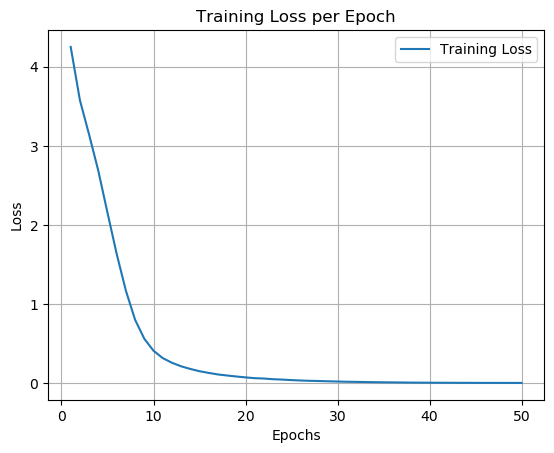

In [21]:
# List of losses for each epoch
losses = epoch_loss_output

epochs = list(range(1, len(epoch_loss_output) + 1))

# Plot the training loss
plt.plot(epochs, losses, label='Training Loss')

# Add title and labels
plt.title('Training Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Display the plot
plt.legend()
plt.grid(True)
plt.show()


### Evaluation Results:


Text(0.5, 1.0, 'Cosine similarity between text and image features')

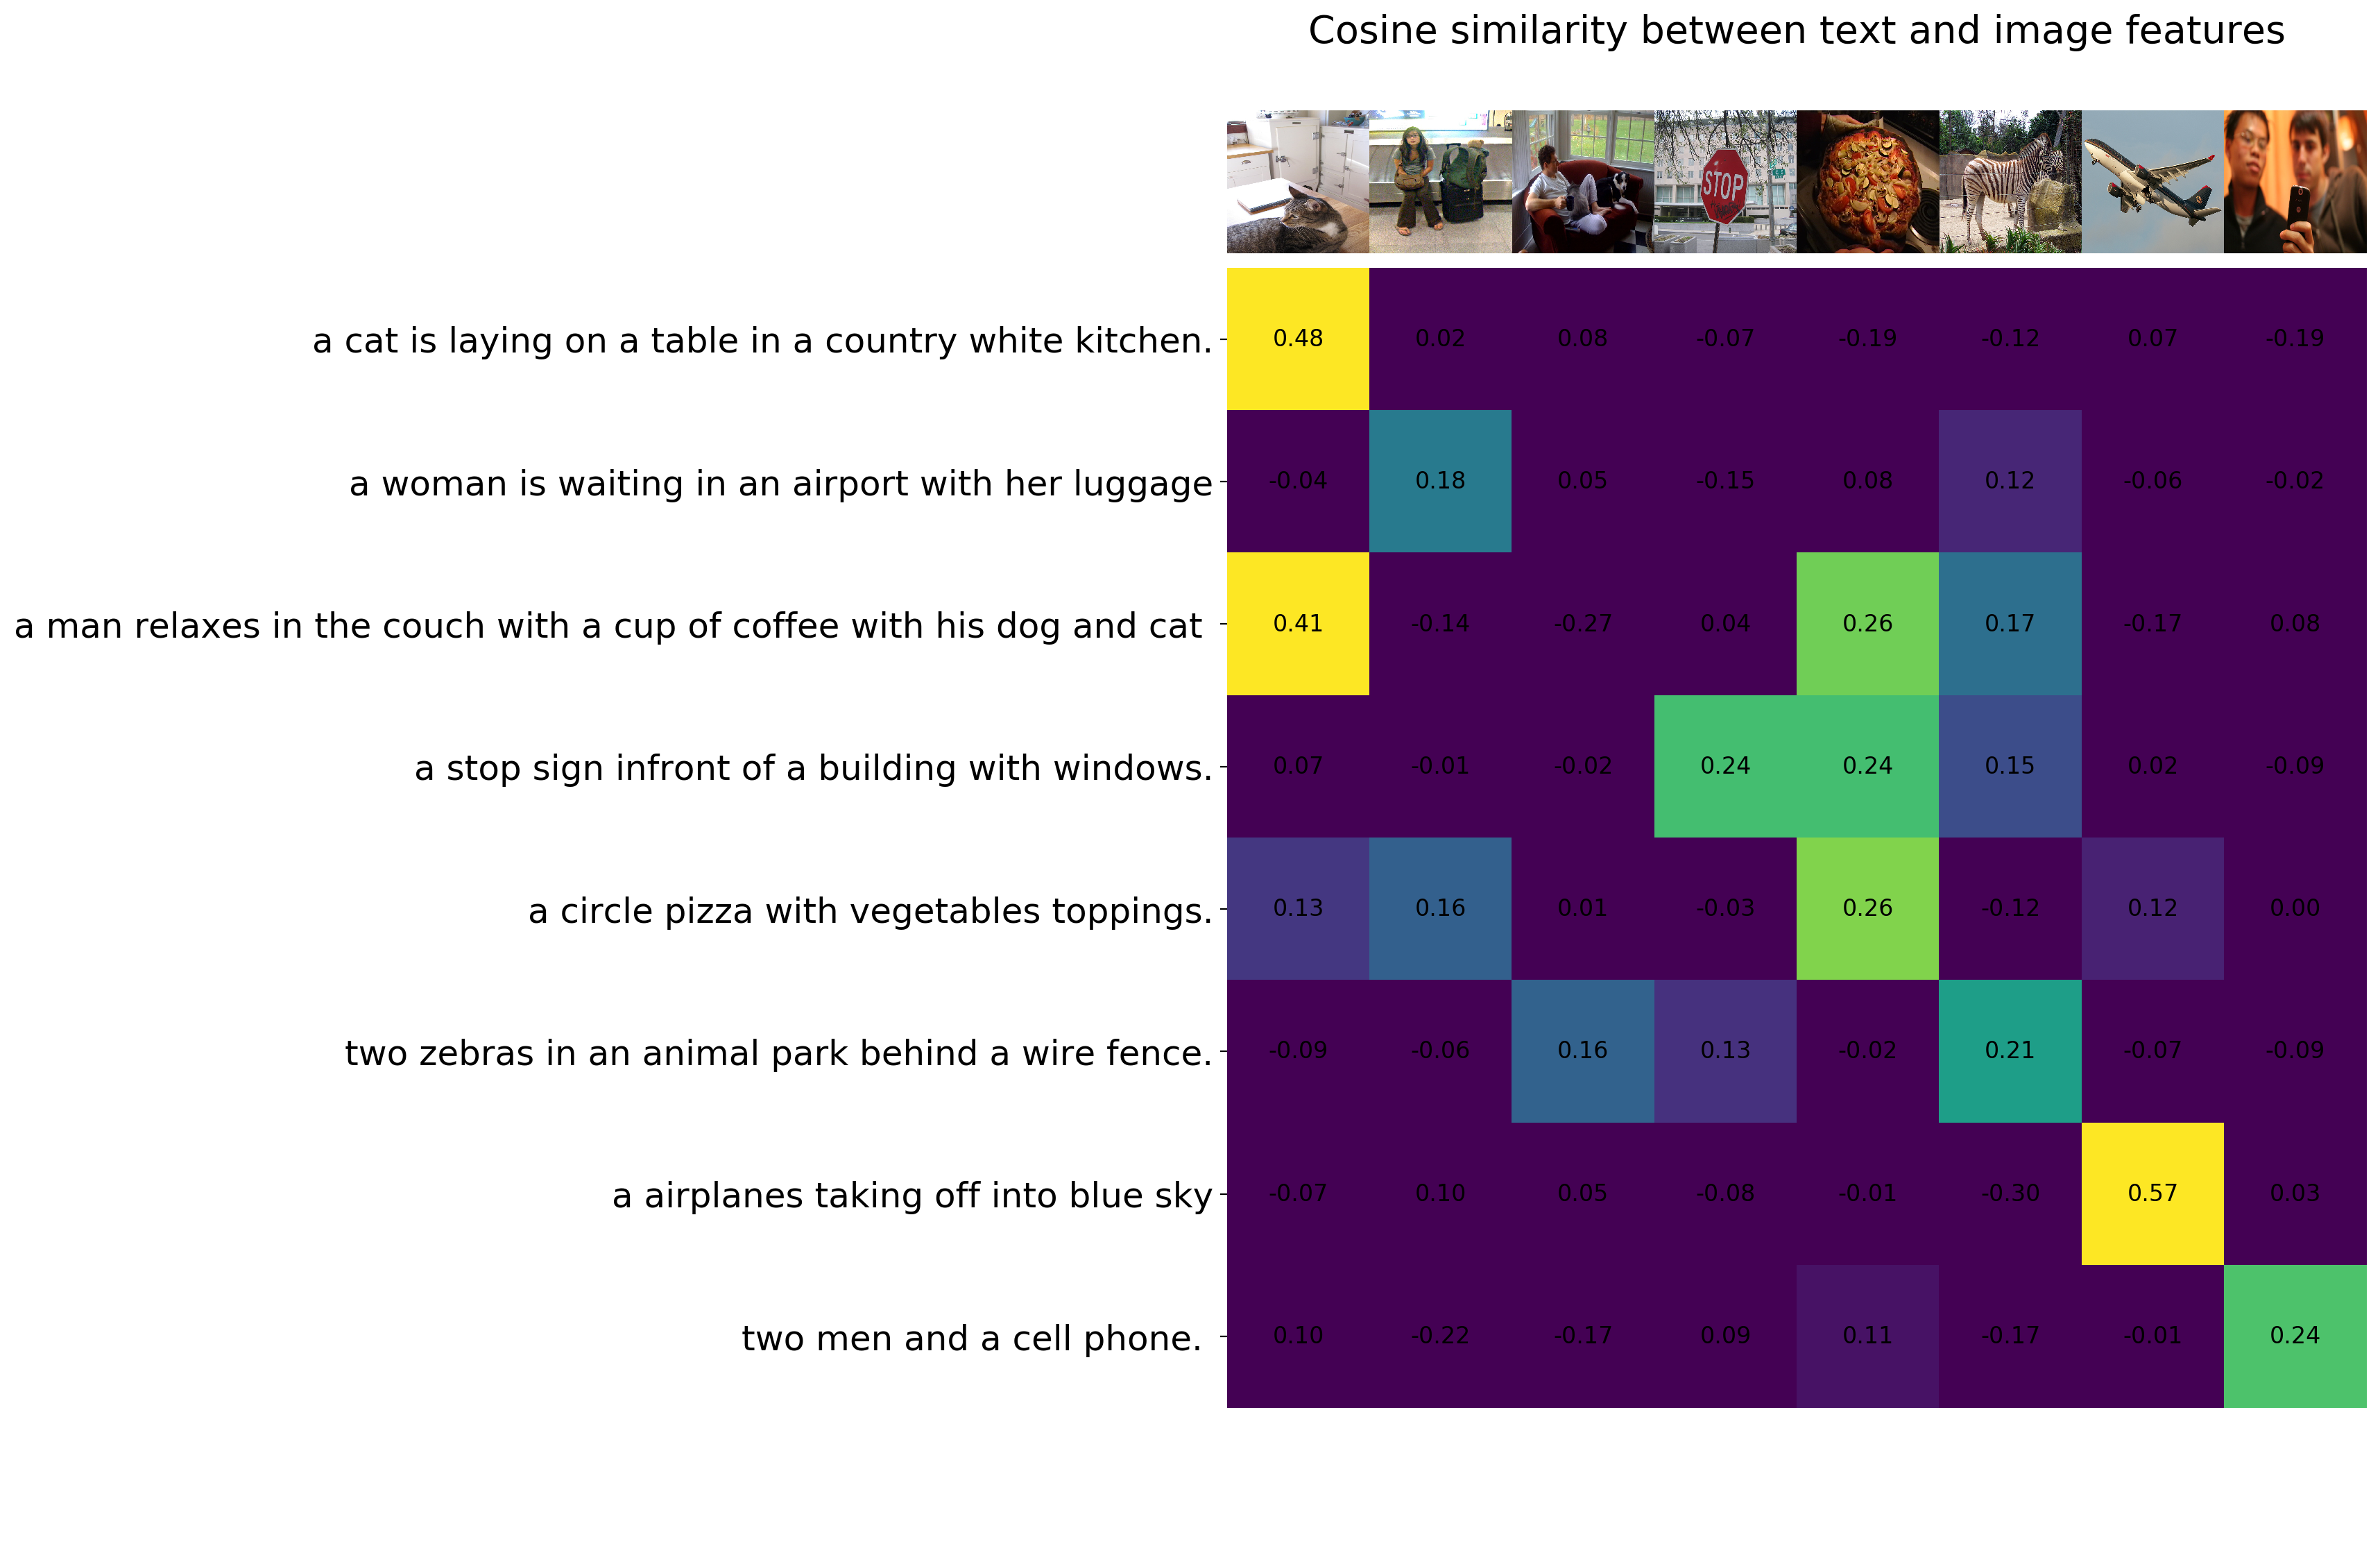

In [40]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
from transformers import AutoTokenizer
import albumentations as A
from albumentations.pytorch import ToTensorV2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

model=CLIP()
checkpoint = torch.load('model_save/checkpoint_20241109_164739.pth', weights_only=True)

model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)


preprocess = A.Compose([
    A.Resize(224, 224),
    A.Normalize(
        mean=[0.48145466, 0.4578275, 0.40821073],
        std=[0.26862954, 0.26130258, 0.27577711]
        ),
    ToTensorV2()
    ])


# images and their textual descriptions
descriptions = {
    "phone": "two men and a cell phone. ",
    "suitcase": "a woman is waiting in an airport with her luggage",
    "zebra": "two zebras in an animal park behind a wire fence.",
    "sign": "a stop sign infront of a building with windows.",
    "pizza": "a circle pizza with vegetables toppings.",
    "cat": "a cat is laying on a table in a country white kitchen.",
    "dog": "a man relaxes in the couch with a cup of coffee with his dog and cat ",
    "airplane": "a airplanes taking off into blue sky",
}


original_images = []
images = []
texts = []
#plt.figure(figsize=(16, 5))

sample_folder = 'sample_images_2'

for filename in [filename for filename in os.listdir(sample_folder) if filename.endswith(".png") or filename.endswith(".jpeg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    # Open the image from the 'sample' folder
    image = Image.open(os.path.join(sample_folder, filename)).convert("RGB")

    #plt.subplot(2, 4, len(images) + 1)
    #plt.imshow(image)
    #plt.title(f"{filename}\n{descriptions[name]}")
    #plt.xticks([])
    #plt.yticks([])
    image = np.array(image)
    transformed=preprocess(image=image)
    original_images.append(image)
    images.append(transformed['image'])
    texts.append(descriptions[name])

#plt.tight_layout()

image_input = torch.tensor(np.stack(images)).to(device)

tokenized_caption = tokenizer(texts, padding='max_length', truncation=True, max_length=77, return_tensors="pt")
text_tokens = tokenized_caption['input_ids'].squeeze()
text_tokens = text_tokens.to(device)

model.eval()
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features @ image_features.T
similarity = similarity.cpu()
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

A cosine similarity matrix between text descriptions (shown on the left) and corresponding images (shown across the top). 
The matrix visualizes how well each text description matches with each image, with values ranging from -1 to 1, where higher values (shown in brighter colors like yellow) indicate stronger similarity.

Looking at the diagonal of the matrix (from top-left to bottom-right), we can see the similarity scores between each text description and its corresponding image:

1. "a cat is laying on a table in a country white kitchen." has a 0.48 similarity with its image
2. "a woman is waiting in an airport with her luggage" has a 0.18 similarity with its image
3. "a man relaxes in the couch with a cup of coffee with his dog and cat " has a -0.27 similarity with its image and 0.41 with cat image(1) 
4. "a stop sign infront of a building with windows." has a 0.24 similarity with its image and 0.24 with stop sign( I think its because of the shape of the sign as it is circle)
5. "a circle pizza with vegetables toppings" has a 0.26 similarity with its image
6. "two zebras in an animal park behind a wire fence." has a 0.21 similarity with its image
7. "a airplanes taking off into blue sky" has a 0.57 similarity with its image
8. "two men and a cell phone" has a 0.24 similarity with its image

The darker purple colors represent lower similarity scores or negative correlations. The airplane description appears to have the strongest correlation with its image (0.57), while some pairs show relatively weak correlation, suggesting varying degrees of success in matching text descriptions to visual content.

## CLIP OpenAi Pre-trained model for comparision
- The model used in this code is **CLIP (Contrastive Language-Image Pre-Training)**, a deep learning model developed by OpenAI. CLIP is designed to understand images and text in a shared feature space.

- We used **ViT-B/32**, which is based on the **Vision Transformer (ViT)** architecture.

- CLIP is trained on a large dataset of images paired with textual descriptions, allowing it to learn rich, cross-modal representations. This enables the model to compare and match images and texts based on their semantic similarity, even if it has never seen a particular image or description during training.

- In this specific usage, the CLIP model encodes both the images and their corresponding textual descriptions, computing feature vectors for each, and then measures the cosine similarity between these vectors to assess how closely they match.

Text(0.5, 1.0, 'Cosine similarity between text and image features')

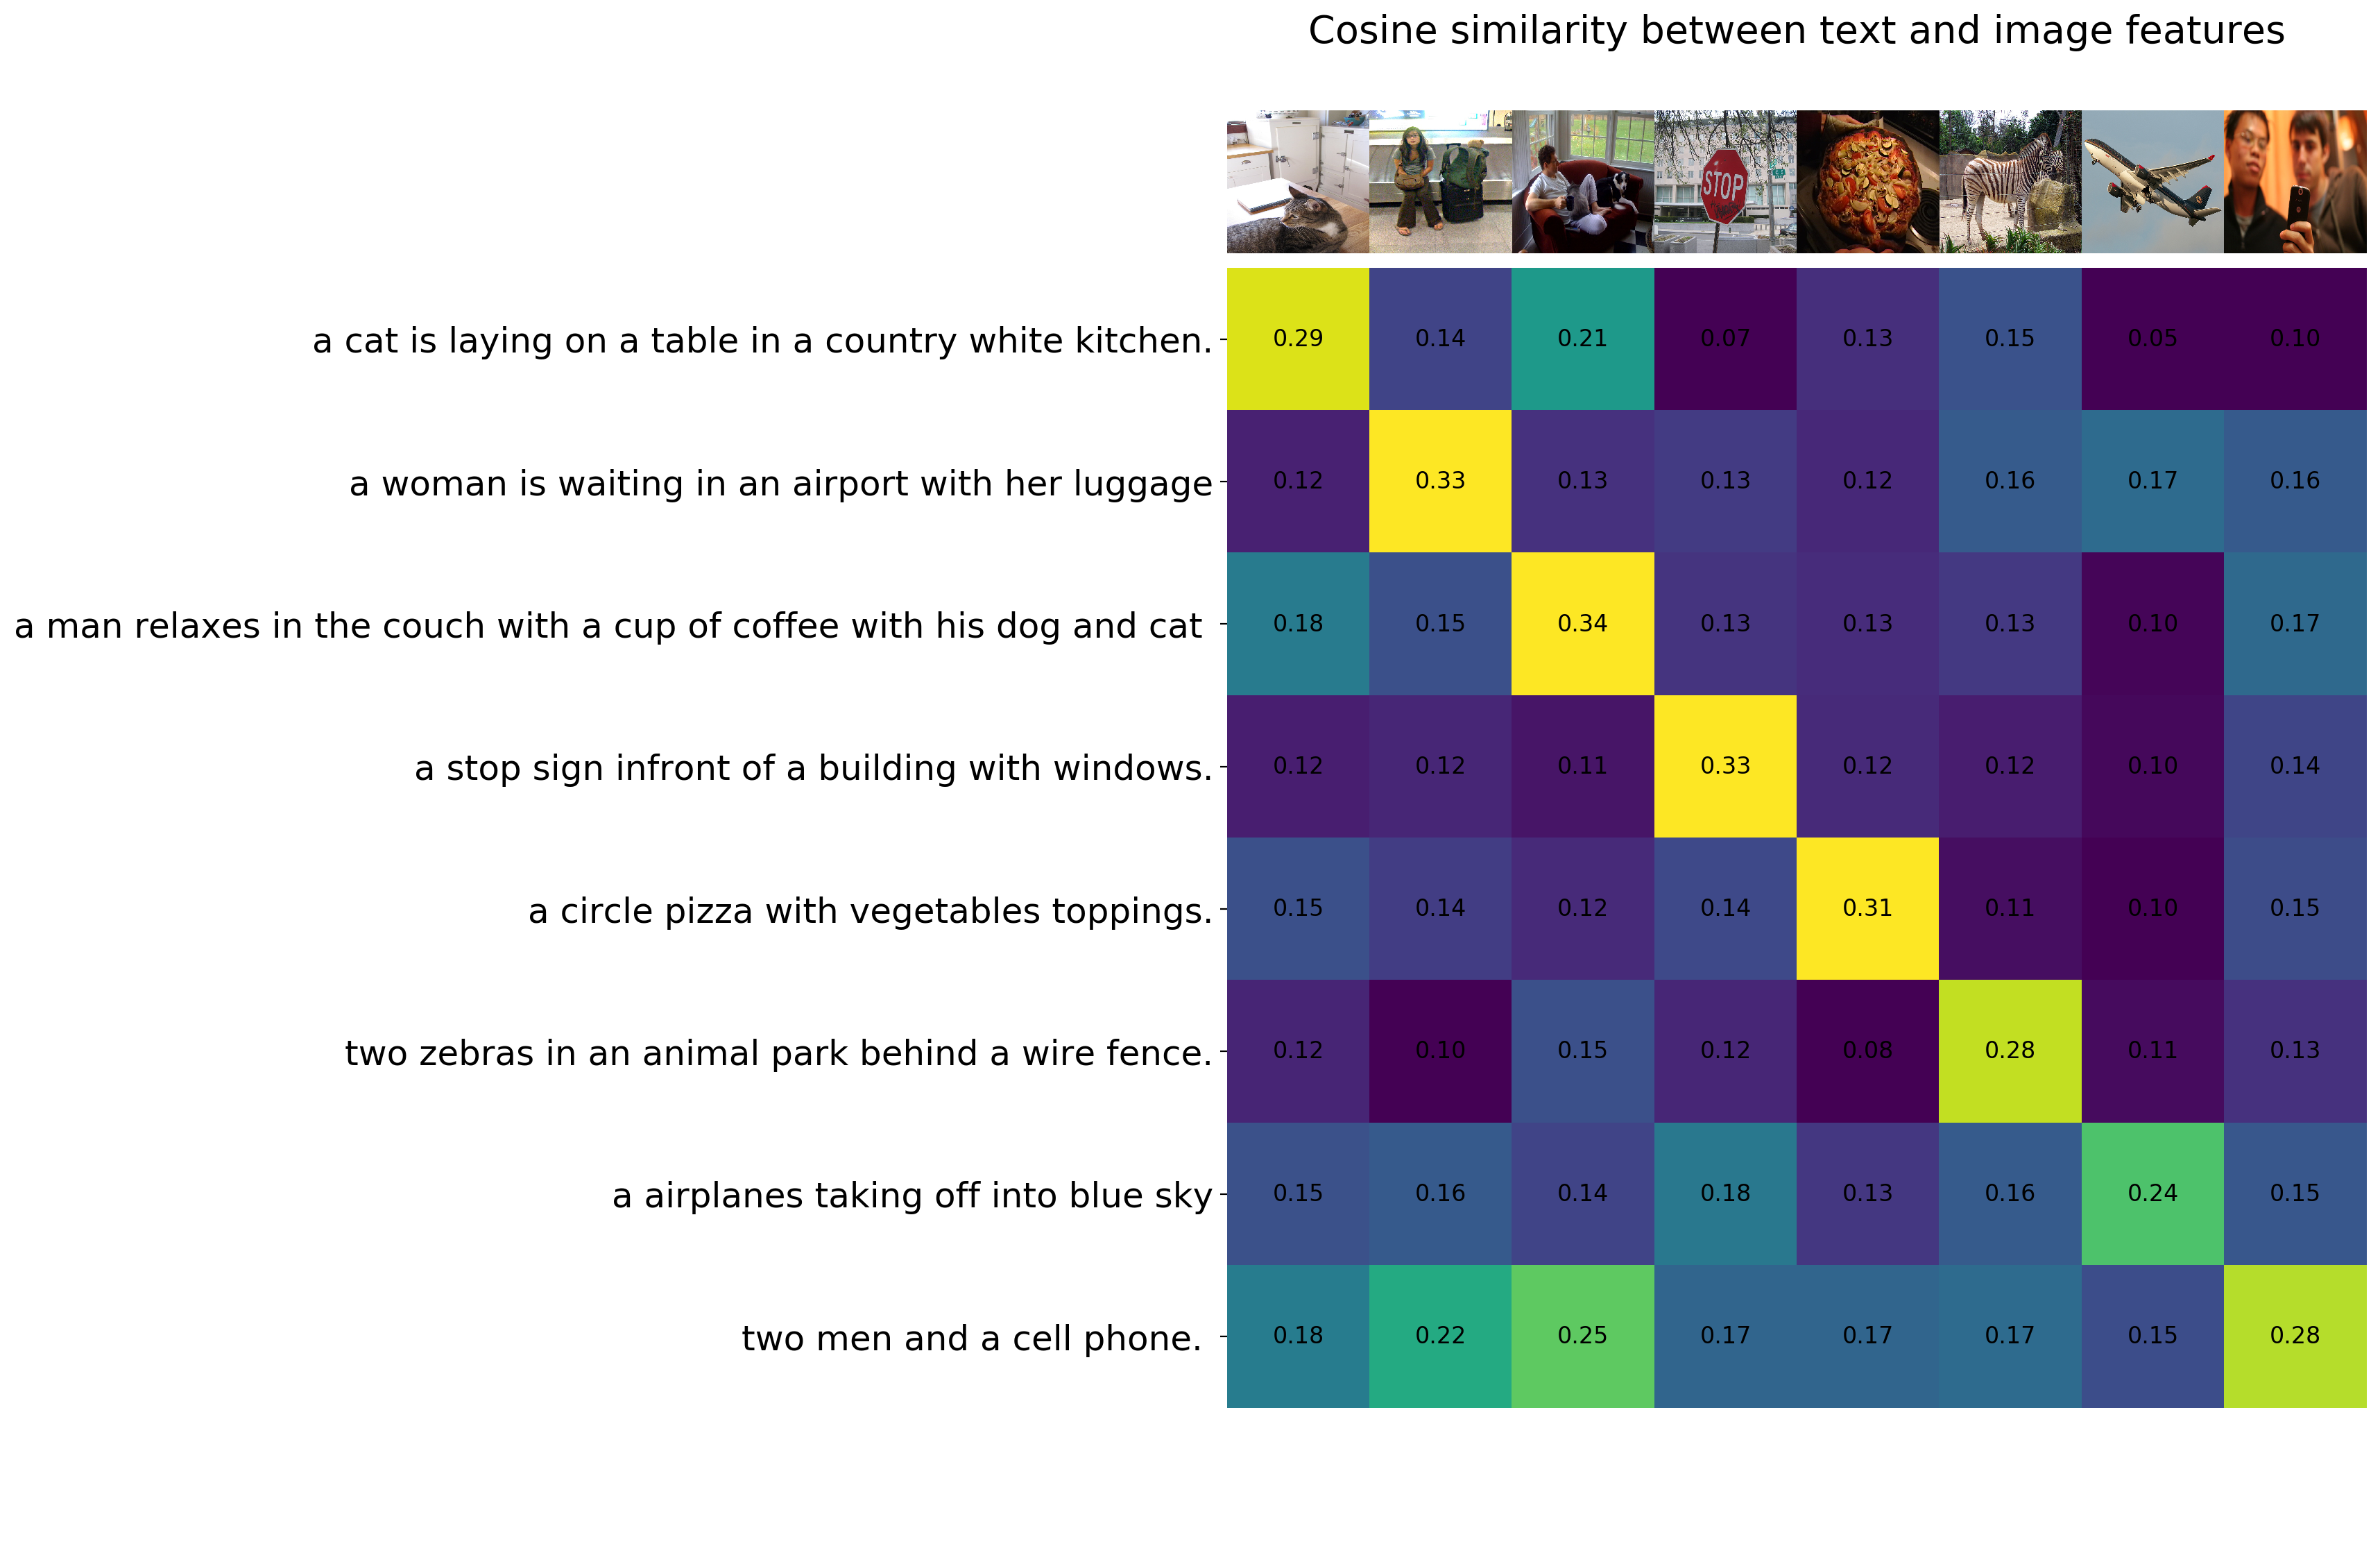

In [39]:
import os

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

import torch
import clip

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

model, preprocess = clip.load("ViT-B/32",device=device)


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "phone": "two men and a cell phone. ",
    "suitcase": "a woman is waiting in an airport with her luggage",
    "zebra": "two zebras in an animal park behind a wire fence.",
    "sign": "a stop sign infront of a building with windows.",
    "pizza": "a circle pizza with vegetables toppings.",
    "cat": "a cat is laying on a table in a country white kitchen.",
    "dog": "a man relaxes in the couch with a cup of coffee with his dog and cat ",
    "airplane": "a airplanes taking off into blue sky",
}
original_images = []
images = []
texts = []
#plt.figure(figsize=(16, 5))


sample_folder = 'sample_images_2'

for filename in [filename for filename in os.listdir(sample_folder) if filename.endswith(".png") or filename.endswith(".jpeg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(sample_folder, filename)).convert("RGB")

    #plt.subplot(2, 4, len(images) + 1)
    #plt.imshow(image)
    #plt.title(f"{filename}\n{descriptions[name]}")
    #plt.xticks([])
    #plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

#plt.tight_layout()

image_input = torch.tensor(np.stack(images)).to(device)
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
ground_clip_similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(ground_clip_similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(ground_clip_similarity.shape[1]):
    for y in range(ground_clip_similarity.shape[0]):
        plt.text(x, y, f"{ground_clip_similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

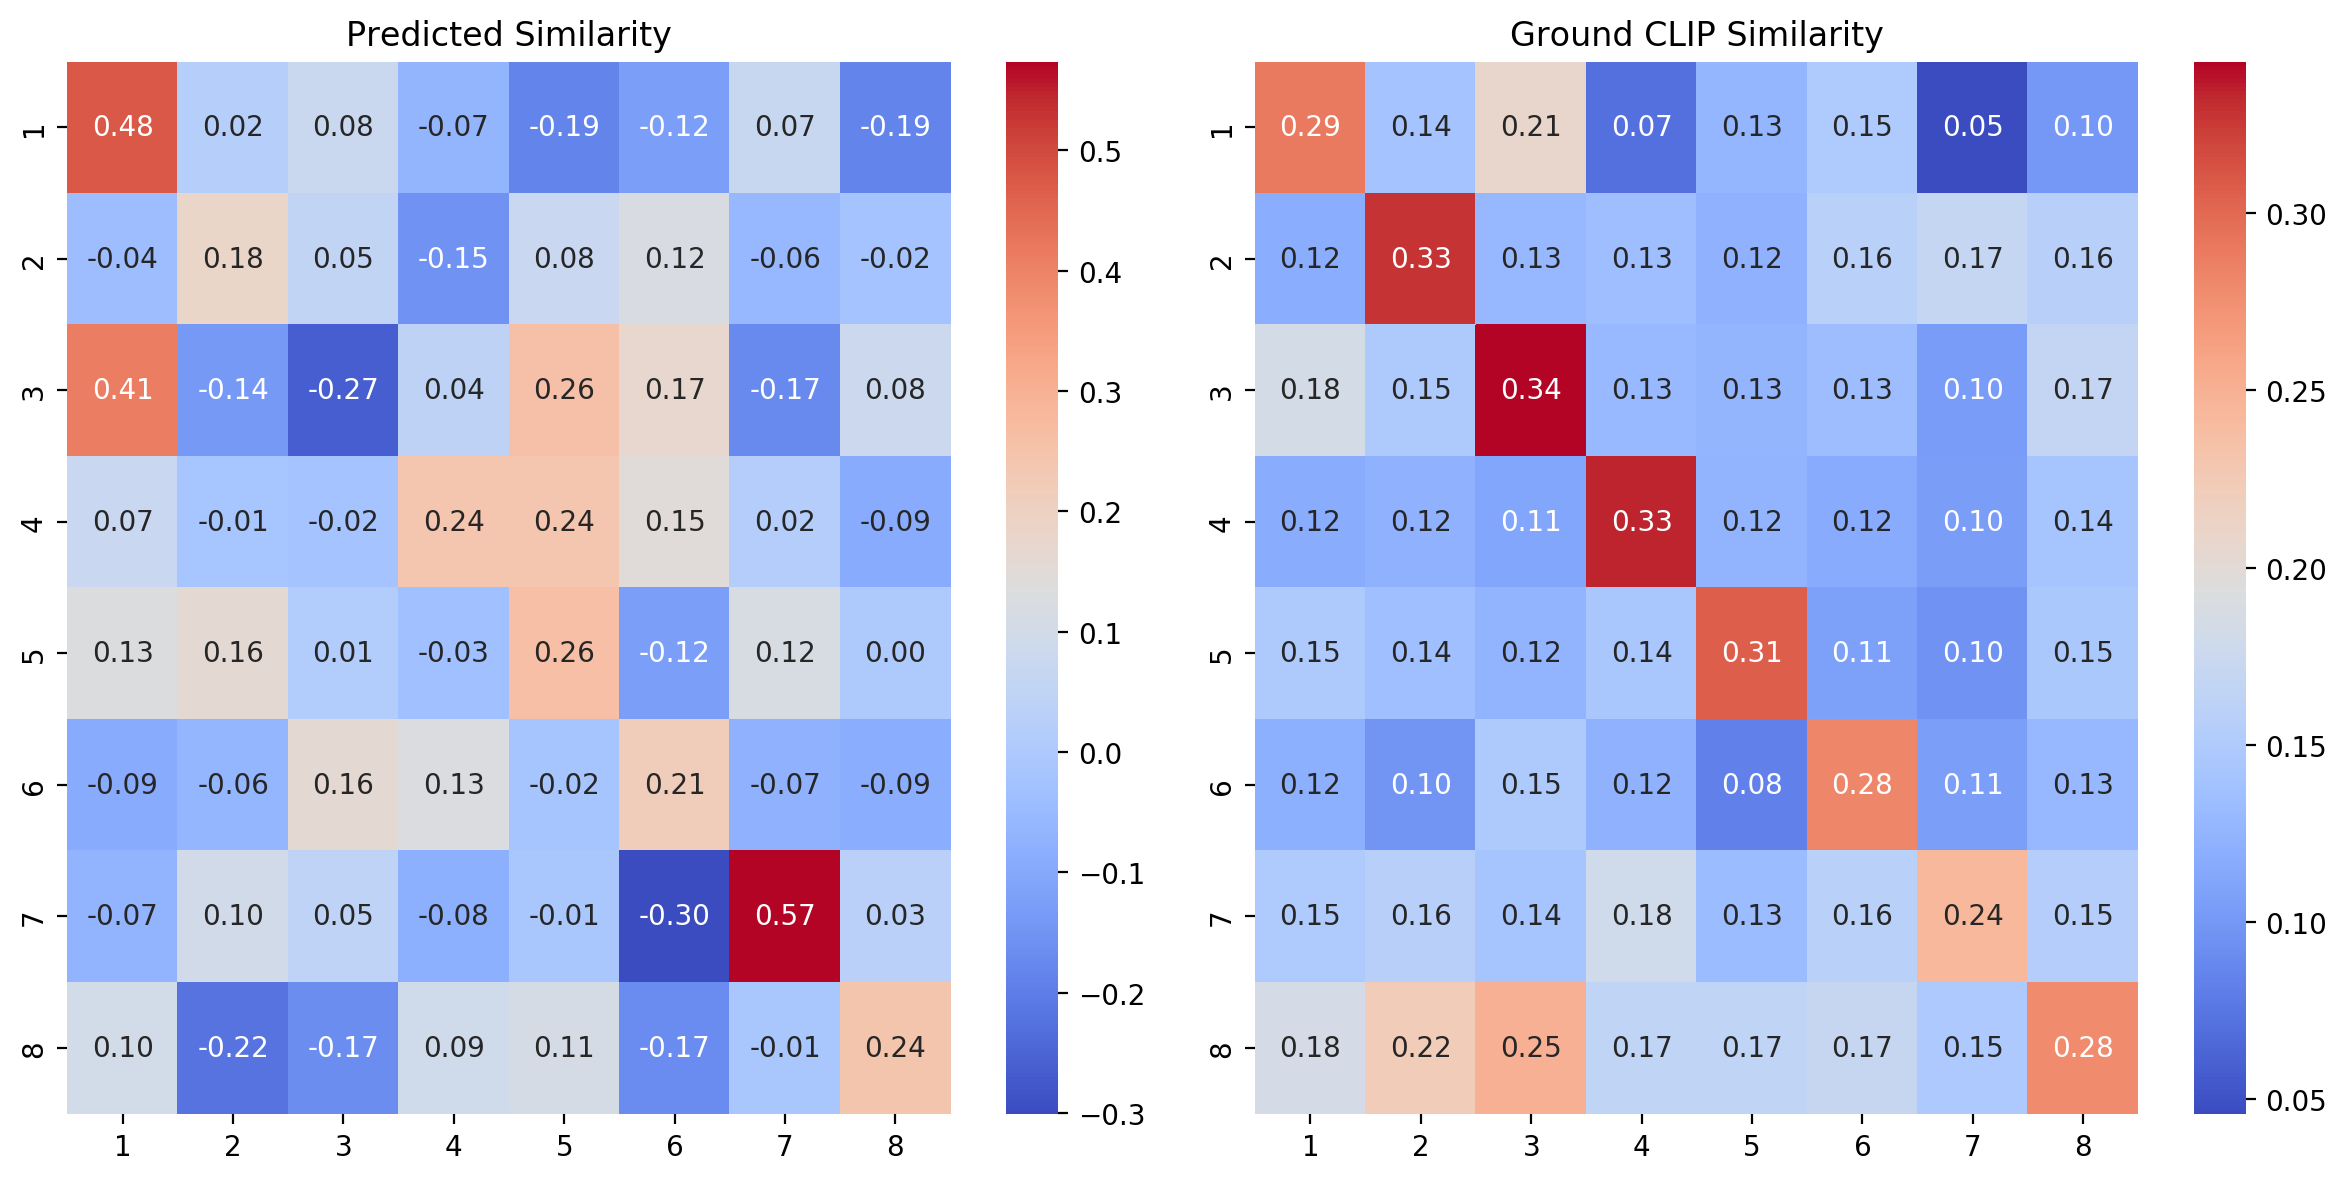

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(similarity, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0])
axes[0].set_title('Predicted Similarity')
axes[0].set_xticklabels(range(1, 9))
axes[0].set_yticklabels(range(1, 9))

sns.heatmap(ground_clip_similarity, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1])
axes[1].set_title('Ground CLIP Similarity')
axes[1].set_xticklabels(range(1, 9))
axes[1].set_yticklabels(range(1, 9))

plt.tight_layout()
plt.show()
